<h1>
  <center>
    Tercer Parcial IA
  </center>
</h1>
<p>
  <center>
    Alejandro Jose Espinel Perez<br>
    Código: 2180027<br>
     Jorge Alfredo Jaimes Teherán<br>
    Código: 2170083<br>
     David Santiago Morales Norato<br>
    Código: 2170102<br>
    Escuela de Ingeniería de Sistemas<br>
    Universidad Industrial de Santander<br>
    2020
  </center>
</p>

<p>
  ------------Problemas---------------------<br>
  +Problema de la secuencia de trabajos(SA)<br>
  +Juego del robot encerrados(SA)<br>
  +Jigsaw Puzzle(GA)<br>
  +Problema de la secuencia de procesadores(GA)<br>
</p>

In [ ]:
#@title 2. LOAD LIB { display-mode: "form" }
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(1201920704)

In [4]:
#@title 1. MONTAR EL DRIVE **student** { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Parcial')

print(os.getcwd())


Mounted at /content/drive
/content/drive/My Drive/Parcial


## Problema de la sequencia de trabajos bajo un deadline(Simmulated Anneling)

Dado un conjunto de trabajos $J = \{J_1, J_2, J_3, ..., J_n\}$, los cuales tienen un tiempo de ejecución $T =\{T_1, T_2, T_3, ..., T_n\}$ y una fecha mínima de finalización $D = \{D_1, D_2, D_3, ..., D_n\}$ 

Encontrar el orden en el cuál se deben desarrollar los trabajos minimizando los retrazos en las entregas de estos.

La función de coste es 

$$ minimize \; X \;\; \sum_{i=0}^{n-1} R_i$$


In [6]:
def iniciar_población(num_trabajos, cantidad_población):
  return [np.random.choice(num_trabajos, size=num_trabajos, replace=False)  for _ in range(cantidad_población)]

In [7]:
def función_coste(orden_trabajos, tiempo_ejecución, fecha_finalización):
  retrazos = np.zeros(shape=(orden_trabajos.size,))
  tiempo_efectuado = 0 
  for idx, trabajo in enumerate(orden_trabajos):
    retrazos[idx] = np.maximum(0, tiempo_efectuado -fecha_finalización[idx] )
    tiempo_efectuado += tiempo_ejecución[orden_trabajos[idx]]

  #print("Tiempo total teórico: ", np.sum(tiempo_ejecución), "  Tiempo total experimental: ",tiempo_efectuado )
  return np.sum(retrazos)



In [8]:
def mutación(orden_trabajos):

  idx1, idx2 = np.random.choice(orden_trabajos.size, size=2, replace=False)
  nuevo_orden_trabajos = orden_trabajos.copy()
  nuevo_orden_trabajos[idx1] = orden_trabajos[idx2]
  nuevo_orden_trabajos[idx2] = orden_trabajos[idx1]
  return nuevo_orden_trabajos

In [9]:
NUM_J = 100
MAX_TIEMPO_J = 50
MAX_DIAS = 200
CANT_POBLA = 500

tiempo_ejecución = np.random.randint(MAX_TIEMPO_J, size=NUM_J)
fecha_finalización = np.random.choice(MAX_DIAS,size=NUM_J, replace=False)

In [10]:
%%writefile sa.py

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

def plot_evolution(bests, means, stds):
    plt.plot(means, label="means")
    plt.plot(bests, label="bests")
    plt.fill_between(range(len(means)), means-stds, means+stds, color="yellow", alpha=0.2)
    plt.legend()

def run_sa(n_individuals, n_cooling_steps, init_population_function, cost_function, generate_neighbor_function):

    pop = init_population_function(n_individuals)

    mean_costs = []
    std_costs  = []
    best_costs = []
    best_sols  = []

    min_cost = np.inf
    min_sol  = None

    for T in tqdm(np.linspace(1,0,n_cooling_steps)):
        costs = []
        for i in range(len(pop)):
            sol = pop[i]
            cost_sol = cost_function(sol)

            # generate a neighbour
            nbr = generate_neighbor_function(sol)
            cost_nbr = cost_function(nbr)

            # if the neighbour is better
            if cost_nbr<cost_sol or np.random.random()<T:
                sol = nbr
                cost_sol = cost_nbr

            pop[i] = sol
            costs.append(cost_sol)

            if cost_sol < min_cost:
                min_sol  = np.copy(pop[i])
                min_cost = cost_function(pop[i])

        best_costs.append(np.min(costs))
        mean_costs.append(np.mean(costs))
        std_costs.append(np.std(costs))

    mean_costs = np.array(mean_costs)
    std_costs  = np.array(std_costs)
    best_costs = np.array(best_costs)
    
    return min_sol, best_costs, mean_costs, std_costs


Overwriting sa.py


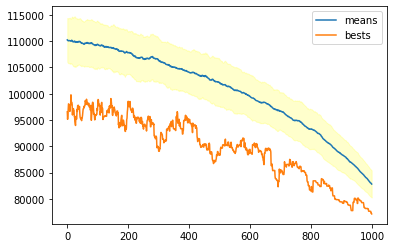

In [11]:
%run sa.py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def TSP_plot_result(best, bests, means, stds):
    plot_evolution(bests, means, stds)


n_individuals = 200
n_cooling_steps = 1000


bestsol, bests, means, stds = run_sa(n_individuals              = n_individuals, 
                                     n_cooling_steps            = n_cooling_steps, 
                                     init_population_function   = lambda cant_pob: iniciar_población(cantidad_población = cant_pob,num_trabajos = NUM_J), 
                                     cost_function              = lambda orden: función_coste(orden_trabajos=orden, tiempo_ejecución = tiempo_ejecución, fecha_finalización = fecha_finalización),
                                     generate_neighbor_function = mutación)


TSP_plot_result(bestsol, bests, means, stds)

#Juego del robot encerrado (Simmulated Anneling) 

<p>En este primer ejercicio consisten en un juego en el cual un robot tiene que conseguir la llave para salir del cuarto
El robot esta encerrado en una habitacion para salir debe encontrar primero la llave y luego encontrar la puerta con el minimo costo (en este caso la minima cantidad de pasos posibles) Es parecido al que hicimos en clases con la diferencia que primero tiene que conseguir las llaves al menor costo</p>
<img src='https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/robot_comic1.png' style="width:350px;">

In [ ]:
mapa=[[1,1,1,1,1,1,1,1,1,1],
      [1,0,0,0,0,0,0,0,0,1],
      [1,0,0,0,0,0,0,0,0,1],
      [1,0,0,0,0,0,0,0,0,1],
      [1,0,0,0,0,0,0,0,0,1],
      [1,0,0,0,0,0,0,0,0,1],
      [1,0,0,0,0,0,0,0,0,1],
      [1,0,0,0,0,0,0,0,0,1],
      [1,1,1,1,1,1,1,1,1,1]]
##coordenada de las llaves      
kx=len(mapa)-2
ky=len(mapa)-2
##coordenada de la puerta
px=len(mapa)-2
py=1

N=30

In [ ]:
class Juego:
  def __init__(self,mapa):
    self.mapa=mapa
    self.x=1
    self.y=1

  def get_xy(self):
    r=[self.y,self.x]
    return r
  
  def moverUp(self):
    dx=self.x
    dy=self.y-1
    if mapa[dy][dx]==0:
      self.x=dx
      self.y=dy
  def moverDown(self):
    dx=self.x
    dy=self.y+1
    if mapa[dy][dx]==0:
      self.x=dx
      self.y=dy    

  def moverRight(self):
      dx=self.x+1
      dy=self.y
      if mapa[dy][dx]==0:
        self.x=dx
        self.y=dy

  def moverLeft(self):
        dx=self.x-1
        dy=self.y
        if mapa[dy][dx]==0:
          self.x=dx
          self.y=dy


In [ ]:
def mostrar(mapa,mx,my):
  for i in range(0,len(mapa)):
    for j in range(0,len(mapa[0])):
      bandera=0
      if j==mx and i==my:
        print("X",end="")
        bandera=1
        continue
        
      if j==kx and i==ky:
        print("K",end="")
        bandera=1
      if j==px and i==py: 
        print("P",end="")
        bandera=1
      if bandera==1:
        continue  
      if mapa[i][j]==0:
        print(" ",end="")
      if mapa[i][j]==1:
        print("#",end="") 
      if mapa[i][j]==2:
        print("X",end="")   
    print()  

In [ ]:
obj=Juego(mapa)
mostrar(obj.mapa,1,1)

##########
#X     P #
#        #
#        #
#        #
#        #
#        #
#      K #
##########


In [ ]:
def KS_initialize_population(n_individuals):
  import numpy as np
  r = []
  opc=[0,1,2,3,4]
  size=N
  for i in range(n_individuals):
    solucion=np.zeros(size,dtype=int)
    rand=np.random.randint(1,20)
    for k in range(rand):
      sel_opc=len(opc)
      indice=np.random.randint(0,size)
      m=np.random.randint(0,sel_opc)
      solucion[indice]=opc[m]

    r.append(list(solucion))
  return np.array(r)   

In [ ]:
 p=KS_initialize_population(10)

In [ ]:
def TSP_cost(solution):
    return N-(list(solution).count(0))

In [ ]:
def TSP_neighbour(solution):
    r = []
    opc=[0,1,2,3,4]
    sel_opc=len(opc)
    size=N
    indice=np.random.randint(0,size)
    m=np.random.randint(0,sel_opc)
    solution[indice]=opc[m]
    r=list(solution)
    return r

In [ ]:
print(p[0])

[0 0 0 0 0 0 4 1 0 4 0 2 4 0 0 3 1 0 1 0 1 0 0 1 0 2 0 2 0 2]


In [ ]:
print(TSP_cost(p[0]))

13


In [ ]:
print(TSP_neighbour(p[0]))

[0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 2, 4, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0, 2, 0, 2]


In [ ]:
def jugar_partida(steps):
  partida=Juego(mapa)
  bandera=0
  bandera_key=0
  cont=0
  for i in steps:
    if i==0:
      continue
    if i==1:
      partida.moverUp()
    if i==2:
      partida.moverDown()
    if i==3:
      partida.moverRight()
    if i==4:
      partida.moverLeft()
    xy=partida.get_xy()

    if xy[1]==kx and xy[0]==ky:
      bandera_key=1
    if (xy[1]==px and xy[0]==py) and bandera_key==1:
      bandera=1
      indice=cont
  return bandera


In [ ]:
def run_sa(n_individuals, n_cooling_steps, init_population_function, cost_function, generate_neighbor_function):
    pop = init_population_function(n_individuals)
    mean_costs = []
    std_costs  = []
    best_costs = []
    best_sols  = []

    min_cost = np.inf
    min_sol  = None

    for T in list(np.linspace(1,0,n_cooling_steps)):
        costs = []
        for i in range(len(pop)):
            sol = pop[i]
            cost_sol = cost_function(sol)

            # generate a neighbour
            nbr = generate_neighbor_function(sol)
            cost_nbr = cost_function(nbr)

            # if the neighbour is better
            if cost_nbr<cost_sol or np.random.random()<T:
                sol = nbr
                cost_sol = cost_nbr

            pop[i] = sol
            costs.append(cost_sol)

            partida=Juego(mapa)
            steps=list(pop[i])
            bandera=jugar_partida(steps)


            if bandera==1:
              if min_sol==None:
                min_sol=steps
              else:
                a=cost_function(min_sol)
                b=cost_function(steps)
                if a>b:
                  min_sol=steps
              
        best_costs.append(np.min(costs))
        mean_costs.append(np.mean(costs))
        std_costs.append(np.std(costs))

    mean_costs = np.array(mean_costs)
    std_costs  = np.array(std_costs)
    best_costs = np.array(best_costs)
    
    return min_sol, best_costs, mean_costs, std_costs
    

In [ ]:
min_sol=None
cont=0
while min_sol==None or cont==10:
  min_sol, best_costs, mean_costs, std_costs=run_sa(200, 500, KS_initialize_population, TSP_cost, TSP_neighbour)
  cont=cont+1

In [ ]:
print(min_sol)
#print(best_costs)
#print(mean_costs)
#print(std_costs)

[2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 0, 2, 3, 4, 1, 0, 1, 1, 1, 2, 4, 1, 1, 4, 1, 2, 3, 1, 3]


In [ ]:
play=Juego(mapa)
coordenadas=[]
for i in min_sol:
  if i==1:
    play.moverUp()
  if i==2:
    play.moverDown()
  if i==3:
    play.moverRight()
  if i==4:
    play.moverLeft()
  xy=play.get_xy()
  coordenadas.append((xy[1],xy[0]))

indice=coordenadas.index((px,py))
respuesta_final=np.zeros(N,dtype=int)
prob=np.array(min_sol)
respuesta_final=prob[0:indice]
respuesta_final=list(respuesta_final)
while respuesta_final.count(0)>0:
  respuesta_final.remove(0)
print(respuesta_final)
print("cantidad minima de pasos encontrada")
print(len(respuesta_final))
print(coordenadas[:indice])
if coordenadas[indice]==(px,py):
  print("CORRECTO")

[2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 4, 1, 1, 1, 1, 2, 4, 1, 1, 4, 1, 2, 3, 1]
cantidad minima de pasos encontrada
27
[(1, 2), (1, 3), (2, 3), (3, 3), (3, 4), (4, 4), (4, 5), (5, 5), (5, 6), (6, 6), (7, 6), (7, 6), (7, 7), (8, 7), (7, 7), (7, 6), (7, 6), (7, 5), (7, 4), (7, 3), (7, 4), (6, 4), (6, 3), (6, 2), (5, 2), (5, 1), (5, 2), (6, 2), (6, 1)]
CORRECTO


#Jigsaw puzzle(GA)

In [ ]:
!ls content/

ls: cannot access 'content/': No such file or directory


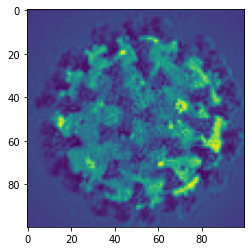

In [12]:
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
img = io.imread("cor.jpg",as_gray=True)
width, height = img.shape[0], img.shape[1]
plt.imshow(img)

In [13]:
img.shape

(100, 100)

In [14]:
print(img)

[[0.11905373 0.11905373 0.12297529 ... 0.17003412 0.17003412 0.17003412]
 [0.15826941 0.15826941 0.16219098 ... 0.17003412 0.17003412 0.17003412]
 [0.16611255 0.17003412 0.17003412 ... 0.17003412 0.17003412 0.17003412]
 ...
 [0.17787725 0.17787725 0.17787725 ... 0.17787725 0.17787725 0.17787725]
 [0.17787725 0.17787725 0.17787725 ... 0.17787725 0.17787725 0.17787725]
 [0.17395569 0.17395569 0.17787725 ... 0.17787725 0.17787725 0.17787725]]


In [15]:
original=img

In [16]:
dictionary={}

In [17]:
###divido las piezas
for i in range(100):
  dictionary[i]=list(img[i][:]) 
print(dictionary[0])

[0.11905372549019608, 0.11905372549019608, 0.12297529411764706, 0.12689686274509804, 0.13081843137254903, 0.13081843137254903, 0.13474, 0.13474, 0.13474, 0.13474, 0.138661568627451, 0.138661568627451, 0.138661568627451, 0.14258313725490196, 0.14258313725490196, 0.14258313725490196, 0.14191882352941176, 0.14389098039215686, 0.1481180392156863, 0.1503956862745098, 0.1568627450980392, 0.15716823529411764, 0.15716823529411764, 0.15629725490196078, 0.1649737254901961, 0.16383490196078432, 0.16383490196078432, 0.16048666666666667, 0.1627643137254902, 0.16587529411764707, 0.1681529411764706, 0.16731960784313726, 0.19123764705882354, 0.16768549019607842, 0.16426901960784315, 0.18913686274509806, 0.19551294117647056, 0.17754901960784314, 0.16464549019607844, 0.17167803921568628, 0.18374823529411768, 0.1664180392156863, 0.16757960784313727, 0.19141450980392158, 0.2113278431372549, 0.20348470588235296, 0.18863176470588236, 0.18078862745098043, 0.1885564705882353, 0.18238000000000001, 0.1890615686

In [18]:
def mostrar_img(arr):
  aux=[]
  for i in arr:
    aux.append(i)
  r=np.array(aux)
  plt.imshow(r)


In [20]:
desordenada=np.random.permutation(100)
print(desordenada)

[22 46 83 29 94 35 67 56 16 86 77 49 75 54 85 40 33 91 89 65 21 38  2 15
 44 45 92 79 61 51 62  1 14 63 11  5  9 32 97 18 42 25 74 88 19 69 34 66
 55 24  7  6 93 52 90 12 37 81 98 36 58 82 23 73 87 57  3 26 99 47 80 28
  8 72 59 17 39 70 53 68  4 96 95 71  0 84 13 27 48 20 10 41 76 43 50 78
 30 64 60 31]


<Figure size 1080x288 with 0 Axes>

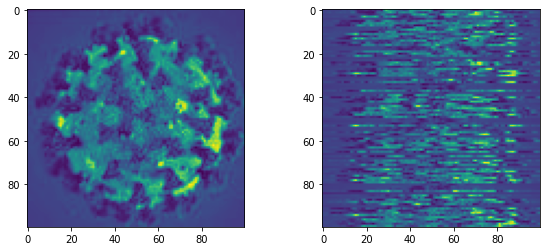

In [21]:
xxd=[]
for i in range(100):
  xxd.append(dictionary[i])

plt.figure(figsize=(15,4))
pp=[]
for i in desordenada:
  pp.append(dictionary[i])

plt.figure(figsize=(15,4))
plt.subplot(131);
mostrar_img(xxd)  
plt.subplot(132);
mostrar_img(pp)  



In [22]:
def TSP_cost(arr):
  solution=list(arr)
  cont=0
  for i in range(len(solution)-1):
    if solution[i]==solution[i+1]+1:
      cont=cont+1  
  return len(solution)-cont

In [23]:
print(TSP_cost(desordenada))

98


In [24]:
def TSP_initialize_population(n_individuals, piezas):
    r = []
    for i in range(n_individuals):
        r.append(np.random.permutation(piezas))
    return np.array(r)

In [25]:
def TSP_cross_over(solution1, solution2):
    l = len(solution1)
    cstart = np.random.randint(l)
    cend   = np.random.randint(l-cstart)+cstart+1
    r = np.zeros(l)
    s1part = solution1[cstart:cend]
    r[cstart:cend] = s1part
    c = 0
    for i in range(l):
        c = cend if c==cstart else c
        if not solution2[i] in s1part:
            r[c]=solution2[i]
            c += 1  
    return r

In [26]:
def TSP_mutate(solution, mutation_prob):
    mutated_solution = np.copy(solution)
    for i in range(len(solution)):
        if np.random.random()<mutation_prob:
            j = i+1 if i!=len(solution)-1 else 0
            tmp = mutated_solution[i]
            mutated_solution[i] = mutated_solution[j]
            mutated_solution[j] = tmp
    return mutated_solution

In [40]:

def run_ga(pop_size, init_population_function, 
           mutation_function, crossover_function, cost_function, 
           crossover_prob, mutation_prob, n_iters):

    pop = init_population_function(pop_size,100)
    n_xover_indivs = int(pop_size * crossover_prob)

    means = []
    stds  = []
    best_costs = []
    best = None

    for i in range(n_iters):

        offsprings = []
        permut_temp = np.random.permutation(len(pop))
        idx_xover_indivs = permut_temp[n_xover_indivs:]

        for idx in idx_xover_indivs:
            idx_counterpart = np.random.randint(len(pop))
            i1 = pop[idx]
            i2 = pop[idx_counterpart]
            offs = crossover_function(i1,i2)
            offsprings.append(offs)
        offsprings = np.array(offsprings)

        pop = np.vstack((pop, offsprings)).astype(int)

        # mutate population
        for j in range(len(pop)):
            pop[j] = mutation_function(pop[j], mutation_prob)

        # select best to maintain pop_size fixed
        costs = np.array([cost_function(j) for j in pop])
        top_idxs  = np.argsort(costs)[:pop_size]
        pop = pop[top_idxs]

        costs = costs[top_idxs]

        means.append(np.mean(costs))
        stds.append(np.std(costs))
        best_costs.append(np.min(costs))
        
        if best is None or np.min(costs) < cost_function(best):
             best = pop[np.argmin(costs)]

    means      = np.array(means)
    stds       = np.array(stds)
    best_costs = np.array(best_costs)
    
    
    return best, best_costs, means, stds


In [58]:
best, best_costs, means, stds=run_ga(1000, TSP_initialize_population,TSP_mutate, TSP_cross_over, TSP_cost, 0.3, 0.6, 100)


In [59]:
print(best)
print(np.min(best_costs))

[68 97 43 65 45 40 14 51 81 90 52 66 54 25 76 31 57 60 73 32 67 27 21 88
 20 74 47 46 28 82 64 63 10 13 30 29 36 49 72 69  5 24 95 77 61 89 50 98
 38 70  9 75 59 94 55 22 85 84 39  4  3  6 78 23 86 71 35 34 33  0 41  8
  7 18 79 58 37 87  2 17 56 16 19 12 11 42 15 26  1 92 99 53 96 91 44 93
 48 83 62 80]
91


<Figure size 1080x288 with 0 Axes>

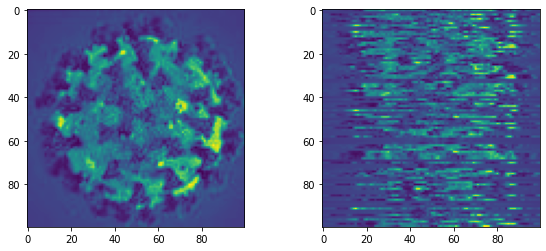

In [60]:
xxd=[]
for i in range(100):
  xxd.append(dictionary[i])
plt.figure(figsize=(15,4))
pp=[]
for i in best:
  pp.append(dictionary[i])
plt.figure(figsize=(15,4))
plt.subplot(131);
mostrar_img(xxd)  
plt.subplot(132);
mostrar_img(pp)  


#Problema de la secuencia procesadores(GA)


Dado un conjunto de procesadores $P = \{P_1, P_2, P_3, ..., P_n\}$, con una frecuencia de ciclos por segundo $V = \{V_1, V_2, V_3, ..., V_n\}$
y un conjunto de trabajos $J = \{J_1, J_2, J_3, ..., J_n\}$, los cuales tienen un tiempo de ejecucción por ciclo $T =\{T_1, T_2, T_3, ..., T_n\}$, se desea optimizar la asignación de trabajos que tarda los el conjunto de procedores $P$ en realizar el conjunto de trabajos $J$ 

In [30]:
import random
import numpy as np

In [31]:
def inicializacion(n_gen, n_jobs, n_procesadores):
  k = []
  jobs=np.array(range(n_jobs))
  len(jobs)
  for i in range(n_gen):
    i, r, t  = np.random.choice(range(1,n_jobs), size=3,replace = False )
    b = np.array([i,r,t])
    b.sort()
    gen = dict.fromkeys(range(n_procesadores-1))
    for i in gen:
      if i==0:
        gen[i] = jobs[:b[i]]
      elif i==3:
        gen[i] = jobs[b[i-1]:]
      else:
        gen[i] = jobs[b[i-1]:b[i]]
    k.append(gen)
  return np.array(k)

In [32]:
def cost_function(gen,processors,jobs):
  max = []
  for i in range(len(gen)): 
    try: 
      a=jobs[gen[i]]/processors[i]
      a=np.sum(a)
      max.append(a) 
    except Exception as e:
      print("I:",i)
      print("GEN:",gen)
      print("GEN[I]:",gen[i])
      print("JOBS:",jobs)
      print("JOBS[GEN[I]]:",jobs[gen[i]])
      print("PROCESSORS:",processors)
      print("pROCESSORS[I]:",processors[i])
      raise e
  max=np.max(max)
  return max

In [33]:
def cross_over(gen1,gen2):
  j,l = np.random.choice(len(gen1), size=2,replace = False )
  aux = np.array([])
  son = dict.fromkeys(range(len(gen1)))
  for i in range(len(gen1)-1):
    if i==0:
      aux = np.append(aux,gen2[i])
      temp = []
      son[i+1] =gen2[i].copy().astype(int)
      #son[i] = gen2[i].copy()
      for j in gen1[i]:
          if not j in aux:
            aux = np.append(aux,j)
            temp.append(j)
      son[i+1]= np.append(son[i+1],temp).astype(int)
    else:
      temp = []
      for j in gen2[i]:
          if not j in aux:
            aux = np.append(aux,j)
            temp.append(j)
      for j in gen1[i]:
        if not j in aux:
          aux = np.append(aux,j)
          temp.append(j)
      son[i+1]=np.array(temp, dtype=int)

  temp = []
  for j in gen2[i]:
      if not j in aux:
        aux = np.append(aux,j)
        temp.append(j)
  for j in gen1[i]:
    if not j in aux:
      aux = np.append(aux,j)
      temp.append(j)
  son[0]=np.array(temp, dtype=int)
  son = mutacion(son,1)
  return son

In [34]:
def mutacion(gen, prob_mutacion):
  if prob_mutacion > np.random.rand():
    idx_min = np.argmin([gen[i].size for i in gen])  
    idx_max = np.argmax([gen[i].size for i in gen])
    elemento1 = gen[idx_max][-1]
    gen[idx_max] = gen[idx_max][:-1]
    gen[idx_min] = np.append(gen[idx_min], elemento1)
  return gen

In [36]:
%%writefile ga1.py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

def plot_evolution(bests, means, stds):
    plt.plot(means, label="means")
    plt.plot(bests, label="bests")
    plt.fill_between(range(len(means)), means-stds, means+stds, color="yellow", alpha=0.2)
    plt.legend()
    

def run_ga(pop_size, init_population_function, 
           mutation_function, crossover_function, cost_function, 
           crossover_prob, mutation_prob, n_iters):

    pop = init_population_function(pop_size)
    n_xover_indivs = int(pop_size * crossover_prob)

    means = []
    stds  = []
    best_costs = []
    best = None

    for i in tqdm(range(n_iters)):

        #if i%(n_iters/10)==0:
        # print i
        
        # do cross over
        offsprings = []
        permut_temp = np.random.permutation(len(pop))
        idx_xover_indivs = permut_temp[n_xover_indivs:]
        #print "permut_temp: ", permut_temp
        #print "idx_xover_indivs: ", idx_xover_indivs
        for idx in idx_xover_indivs:
            idx_counterpart = np.random.randint(len(pop))
            i1 = pop[idx]
            i2 = pop[idx_counterpart]
            offs = crossover_function(i1,i2)
            offsprings.append(offs)
        offsprings = np.array(offsprings)

        pop = np.concatenate((pop,offsprings), axis=0)


        # mutate population
        for j in range(len(pop)):
            pop[j] = mutation_function(pop[j], mutation_prob)

        # select best to maintain pop_size fixed
        costs = np.array([cost_function(j) for j in pop])
        top_idxs  = np.argsort(costs)[:pop_size]
        pop = pop[top_idxs]

        costs = costs[top_idxs]

        means.append(np.mean(costs))
        stds.append(np.std(costs))
        best_costs.append(np.min(costs))
        
        if best is None or np.min(costs) < cost_function(best):
             best = pop[np.argmin(costs)]

    means      = np.array(means)
    stds       = np.array(stds)
    best_costs = np.array(best_costs)
    
    
    return best, best_costs, means, stds

Writing ga1.py


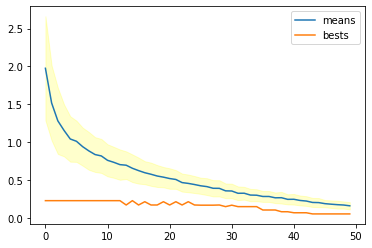

In [37]:
%run ga1.py
processors = [1.5,0.5,1.0,2.0]
n_jobs = 10
jobs = np.random.rand(n_jobs)
n_procesadores = 4
r =  run_ga(pop_size=200,          
               init_population_function = lambda x: inicializacion(x, n_jobs, n_procesadores),  
               mutation_function        = lambda x,y: mutacion(x,y), 
               crossover_function       = cross_over,
               cost_function            = lambda x: cost_function(x,processors,jobs), 
               crossover_prob           = 0.7,
               mutation_prob            = 0.8, 
               n_iters                  = 50)

best, best_costs, means, stds = r
plot_evolution(best_costs, means, stds)